In [1]:
import pandas as pd
import numpy as np

def import_data():
    data = pd.read_csv('norway_new_car_sales_by_make.csv')
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df=pd.pivot_table(data=data, values='Quantity', index='Make', columns='Period', aggfunc='sum', fill_value=0)
    return df

In [2]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
    
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[-y_len], axis=1)
    
    # Test set creation
    
    if test_loops>0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)
    else:  # No test set: X_test is ised to generate the future forecast
        X_test = D[:,-x_len:]
        Y_test = np.full((X_test.shape[0],y_len),np.nan)
        
    # Formatting required for scikit-learn
    
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
    return X_train, Y_train, X_test, Y_test
         

In [3]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops=12)
df.to_excel('demand.xlsx', index=False)


In [4]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'Bias'], index = ['Train', 'Test'])
    df.index.name=name
    df.loc['Train', 'MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100*np.mean((Y_train-Y_train_pred))/np.mean(Y_train)
    df.loc['Test', 'MAE'] = 100*np.mean(abs(Y_test-Y_test_pred))/np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100*np.mean((Y_test-Y_test_pred))/np.mean(Y_test)
    print(df)

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,15)
max_features = range(3,8)
bootstrap = [True]
max_samples = [0.7, 0.8, 0.9, 0.95, 1]

param_dist = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap, 'max_samples': max_samples}
                    
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs=1, verbose=2, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv.fit(X_train, Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.9, min_samples_leaf=11, min_samples_split=5; total time=   0.1s
[CV] END bootstrap

[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=6, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.9, min_samples_leaf=2, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.9, min_sam

[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.7, min_samples_leaf=5, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.7, min_samples_leaf=5, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.7, min_samples_leaf=5, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.7, min_samples_leaf=5, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.7, min_samples_leaf=5, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.7, min_samples_leaf=12, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.7, min_samples_leaf=12, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.7

[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=4, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=4, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=4, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.8, min_samples_leaf=8, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.8, min_samples_leaf=8, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.8, min_samples_leaf=8, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.8, min_samples_leaf=8, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.8, min_s

[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=3, max_samples=1, min_samples_leaf=7, min_samples_split=12; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=3, max_samples=

[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.9, min_samples_leaf=9, min_samples_split=12; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.9, min_samples_leaf=9, min_samples_split=12; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.9, min_samples_leaf=9, min_samples_split=12; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.9, min_samples_leaf=9, min_samples_split=12; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=2, min_samples_split=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=2, min_samples_split=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=2, min_samples_split=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_sa

[CV] END bootstrap=True, max_depth=7, max_features=4, max_samples=0.8, min_samples_leaf=3, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.8, min_samples_leaf=12, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.95, min_

[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=8, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.7, min_samples_leaf=12, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=0.95, 

[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=10, min_samples_split=19; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=10, min_samples_split=19; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=10, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=10, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.7, min_samples_leaf=10, min_samples_split=19; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=0.9, min_samples_leaf=4, min_samples_split=9; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=0.9, min_samples_leaf=4, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, max_

[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=0.7, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=0.7, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samples_leaf=7, min_samples_split=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samples_leaf=7, min_samples_split=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samples_leaf=7, min_samples_split=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samples_leaf=7, min_samples_split=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samples_leaf=7, min_samples_split=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.9, min_samp

[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=1, min_samples_leaf=10, min_samples_split=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=5, max_samples=0.7, mi

[CV] END bootstrap=True, max_depth=8, max_features=6, max_samples=0.7, min_samples_leaf=2, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=6, max_samples=0.7, min_samples_leaf=2, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=6, max_samples=0.7, min_samples_leaf=2, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=6, max_samples=0.7, min_samples_leaf=2, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_s

[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=4, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=3, max_samples=0.7, min_s

[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.8, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.8, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.8, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.8, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_leaf=13, min_samples_split=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_leaf=13, min_samples_split=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_leaf=13, min_samples_split=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_s

[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.9, min_samples_leaf=11, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.9, min_samples_leaf=12, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=15; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=1, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=1, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=4, 

[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=0.7, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=0.7, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=0.95, min_samples_leaf=12, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=0.95, min_samples_leaf=12, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=0.95, min_samples_leaf=12, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=0.95, min_samples_leaf=12, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=0.95, min_samples_leaf=12, min_samples_split=16; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_sa

[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.8, min_samples_leaf=12, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.8, min_samples_leaf=12, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.8, min_samples_leaf=12, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.8, min_samples_leaf=12, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.8, min_samples_leaf=12, min_samples_split=14; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.7, min_samples_leaf=13, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.7, min_samples_leaf=13, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=6, max_samples=0.7

[CV] END bootstrap=True, max_depth=9, max_features=6, max_samples=0.95, min_samples_leaf=4, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=6, max_samples=0.95, min_samples_leaf=4, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, max_features=6, max_samples=0.95, min_samples_leaf=4, min_samples_split=13; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=1, min_samples_

[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=1, min_samples_leaf=12, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=4, max_samples=0.7, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.8, min_sa

[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.7, min_samples_leaf=6, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.7, min_samples_leaf=6, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=3, max_samples=0.7, min_samples_leaf=6, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=6, min_samples_split=17; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=6, min_samples_split=17; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=6, min_samples_split=17; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=6, min_samples_split=17; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_

[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.95, min_samples_leaf=4, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.95, min_samples_leaf=4, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.95, min_samples_

[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=14, min_samples_split=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=14, min_samples_split=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=14, min_samples_split=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.9, min_samples_leaf=6, min_samples_split=11; total time=   0.2s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_sam

[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=1, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=5, min_samples_split=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.9, min_samp

[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.95, min_samples_leaf=14, min_samples_split=18; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.95, min_samples_leaf=14, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.95, min_samples_leaf=14, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.95, min_samples_leaf=14, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.95, min_samples_leaf=14, min_samples_split=18; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.9, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=0.9, min_samples_leaf=13, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=

[CV] END bootstrap=True, max_depth=10, max_features=5, max_samples=1, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=4, max_samples=0.95, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=6, max_samples=0.7, m

[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=1, min_samples_leaf=14, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=0.8, min_samples_leaf=4, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, max_features=6, max_samp

[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.8, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.8, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.8, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.8, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.8, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_leaf=13, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_leaf=13, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_

[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=12; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=12; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=5, max_samples=0.95, min_samples_leaf=13, min_samples_split=12; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=9, min_samples_split=5; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=9, min_samples_split=5; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=9, min_samples_split=5; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_samples=0.8, min_samples_leaf=9, min_samples_split=5; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=7, max_s

[CV] END bootstrap=True, max_depth=6, max_features=3, max_samples=0.9, min_samples_leaf=5, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=0.8, min_samples_leaf=8, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=4, max_samples=1, min_sa

[CV] END bootstrap=True, max_depth=5, max_features=5, max_samples=1, min_samples_leaf=4, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=6, max_samples=0.7, min_samples_leaf=8, min_samples_split=6; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=0.95, min_samples

[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=7, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=7, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=7, min_samples_split=9; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=7, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=4, max_samples=0.95, min_samples_leaf=7, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_samples=0.7, min_samples_leaf=2, min_samples_split=11; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, max_features=7, max_sam

[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=1, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=7, max_features=3, max_samples=0.7, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, max_samples=1, min_samples_lea

[CV] END bootstrap=True, max_depth=None, max_features=6, max_samples=1, min_samples_leaf=2, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, max_features=4, max_samples=0.8, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=1, min_samples_

[CV] END bootstrap=True, max_depth=10, max_features=7, max_samples=1, min_samples_leaf=7, min_samples_split=19; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=3, max_samples=0.7, min_samples_leaf=9, min_samples_split=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=7, max_sample

[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.8, min_samples_leaf=11, min_samples_split=8; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.8, min_samples_leaf=11, min_samples_split=8; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.8, min_samples_leaf=11, min_samples_split=8; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.8, min_samples_leaf=11, min_samples_split=8; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=0.8, min_samples_leaf=11, min_samples_split=8; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.95, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.95, min_samples_leaf=8, min_samples_split=9; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, max_features=7, max_samples=0.95, min_

[CV] END bootstrap=True, max_depth=7, max_features=7, max_samples=1, min_samples_leaf=6, min_samples_split=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=9, max_features=3, max_samples=1, min_samples_leaf=13, min_samples_split=16; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=5, max_samples=0.8, min_samples_l

[CV] END bootstrap=True, max_depth=9, max_features=7, max_samples=0.95, min_samples_leaf=3, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, max_features=7, max_samples=0.95, min_samples_leaf=3, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, max_features=7, max_samples=0.95, min_samples_leaf=3, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, max_features=7, max_samples=0.95, min_samples_leaf=3, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, max_features=7, max_samples=0.95, min_samples_leaf=3, min_samples_split=13; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=1, min_samples_leaf=10, min_samples_split=15; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, max_features=7, max_samples=1, min_

RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [6]:
print('Tuned Forest Parameters', forest_cv.best_params_)
print()
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Tuned Forest Parameters {'min_samples_split': 16, 'min_samples_leaf': 14, 'max_samples': 0.7, 'max_features': 6, 'max_depth': None, 'bootstrap': True}

                        MAE       RMSE      Bias
Forest optimized                                
Train             15.794422  40.612202 -0.096354
Test              18.498061  47.625391  3.758545


In [7]:
## Set estimators = 200 , will be 200 trees

In [11]:
forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)
Y_train_train_pred = forest.predict(X_train)
Y_test_predict = forest.predict(X_test)
kpi_ML(Y_train, Y_train_train_pred, Y_test, Y_test_predict, name = 'Forestx200')

                  MAE       RMSE      Bias
Forestx200                                
Train       15.562845  39.992814  0.031437
Test        18.404569  47.071436  3.585694


In [12]:
# Graph feauture importance

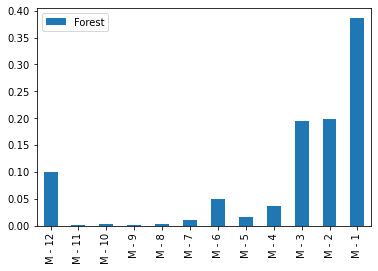

In [14]:
cols = X_train.shape[1] # numer of columns in our training set
features = [f'M - {cols-col}' for col in range(cols)]
data = forest.feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar')